#### PSD e IIA

# QRS detector
#### Francisco Maiocchi

Este trabajo se presentará como trabajo final de las materias Procesamiento de Señales Digital e Introducción a la Inteligencia Artificial de la UTN FRBA Departamento de Electrónica.

***
### Introducción

El electrocardiograma (ECG) es el estudio no invasivo más utilizado para la detección y monitoreo de enfermedades cardíacas. La detección de la posición de los complejos QRS o latidos dentro de la señal resulta fundamental ya que a partir de esto se pueden obtener biomarcadores muy importantes. Realizar esto manualmente requiere mucho tiempo y es una tarea muy repetitiva. Para solucionar este problema, existen gran cantidad de algoritmos y métodos diferentes que detectan latidos automáticamente. 

El problema de estas técnicas es la dificultad que tienen para funcionar correctamente en registros y escenarios distintos. Por ejemplo, no es lo mismo un electrocardiograma de un atleta en ejercicio que el de una persona anciana en reposo. Estos algoritmos suelen desempeñarse de gran forma en un tipo de escenario, pero al analizar uno no conocido, su performance decrece notablemente.

Actualmente, debido a su potencial de adaptación, se comenzó a buscar soluciones a este problema a través del Deep Learning. En este trabajo se introduce un modelo que logra lresultados aceptables y sigrva como punto de partida para el DPLAB.

El dataset utilizado para entrenamiento, testeo y validación es el QT database disponible en https://physionet.org/physiobank/database/#ecg. Esta base de datos cuenta con 105 registros de ECG de dos canales cada uno y una frecuencia de muestreo de 250 Hz. Cada registro consta de tres archivos que brindan distinto tipo de información. Algunos registros fueron descartados ya que las anotaciones no eran coherentes, quedando un total de 82 registros. 

Para alimentar las redes, se dividió cada registro en ventanas de un ancho fijo por lo que cada ejemplo es un array de 512 muestras. Como técnica de data augmentation, las ventanas son solapadas un 75% aumentando así el número de ejemplos. 

Los targets tienen la misma cantidad de muestras que los datos de entrada (512). Constan de un vector de ceros y una ventana de Hamming de 36 muestras por cada anotación del registro. Esto mejoro los resultados obtenidos con targets del tipo one-hot encoder.

De los 82 registros utilizados, se seleccionaron aleatoriamente 58 para el set de entrenamiento, 12 para el set de validación y 12 para el set de testeo. Esto proporciona un nivel relativo de generalización porque si bien todos los registros son de la misma base de datos, esta está compuesta por varias bases diferentes más pequeñas.

Por otro lado, los datasets se normalizaron. A cada ejemplo de entrada se le restó el valor medio y se lo dividió por el desvío estándar tal cual propone el paper _Deep learning based QRS Multilead Delineator in Electrocardiogram signals_. Los labels están normalizados para que el pico de la ventana de Hamming tenga valor unitario.

***
### Imports

In [1]:
# Importo TensorFlow como tf
import tensorflow as tf
# Importo keras
from tensorflow import keras

# Librerias auxiliares
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from IPython.display import HTML
import os
import pandas as pd
import h5py
from scipy import signal as signal

print(tf.__version__)


1.12.0


### Cargar datasets

In [2]:
# Cargo el set de entrenamiento
train_path = 'data/training.npy'
training_set = np.load(train_path)[()]

# Normalizo los datos de entrenamiento
train_input = training_set.get('signals')
train_input = (train_input - np.mean(train_input, axis = 1,  keepdims = True)) / (np.std(train_input, axis = 1,  keepdims = True) + np.finfo(float).eps)

train_label = training_set.get('labels')

# Cargo el set de validación
validation_path = 'data/validation.npy'
validation_set = np.load(validation_path)[()]

# Normalizo los datos de validación
validation_input = validation_set.get('signals')
validation_input = (validation_input - np.mean(validation_input, axis = 1,  keepdims = True)) / (np.std(validation_input, axis = 1,  keepdims = True) + np.finfo(float).eps)

validation_label = validation_set.get('labels')

# Cargo el set de test
test_path = 'data/test.npy'
test_set = np.load(test_path)[()]

# Normalizo los datos de testeo
test_input = test_set.get('signals')
test_input = (test_input - np.mean(test_input, axis = 1,  keepdims = True)) / (np.std(test_input, axis = 1,  keepdims = True) + np.finfo(float).eps)

test_label = test_set.get('labels')

# Definiciones para más adelante
examples = np.random.randint(np.size(test_input,0), size = 10) # Se utiliza para sacar 10 ejemplos al azar del set de entrenamiento

test_input = np.expand_dims(test_input, axis = 2)
train_input = np.expand_dims(train_input, axis = 2)
validation_input = np.expand_dims(validation_input, axis = 2)

***
### Modelo 1


##### Arquitectura

La arquitectura de la red se puede dividir en dos partes principales: 

+ Capas convolucionales.
+ Capas densas.

Las capas convolucionales se utilizan como extractoras de _feautures_ de los datos de entrada. Se probaron diferentes numero de capas y cantidad y tamaño de filtros. Los mejores resultados se obtuvieron con 8 capas de 16 filtros de tamaño 3. 

Para reducir la complejidad dimensional que agregan estas capas, se utilizan _Pooling layers_. Se llegó a mejores resultados  utilizando capas tipo promedio y ubicandolas a la salida de cada capa par. La función activación en está sección es la función *ReLU* (Rectified Linear Unit) que esta definida como $f(x)=max(0,x)$. 

Luego, se utilizan tres capas _fully-connected_. Las primeras dos utilizan dropout para evitar el sobreentrenamiento y la misma función activación de las capas convolucionales. En cambio, la capa de salida utiliza la función sigmoid.

In [11]:
model = keras.Sequential()
# 1
model.add(keras.layers.Conv1D(16, 3, input_shape = (512, 1)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

# 2
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.AveragePooling1D())

# 3
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

# 4
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.AveragePooling1D())

# 5
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

# 6
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.AveragePooling1D())

# 7
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

# 8
model.add(keras.layers.Conv1D(16, 3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.AveragePooling1D())
model.add(keras.layers.Reshape((448,)))

model.add(keras.layers.Dense(128))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(256))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(512, activation = tf.nn.sigmoid))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 510, 16)           64        
_________________________________________________________________
batch_normalization_10 (Batc (None, 510, 16)           64        
_________________________________________________________________
activation_10 (Activation)   (None, 510, 16)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 508, 16)           784       
_________________________________________________________________
batch_normalization_11 (Batc (None, 508, 16)           64        
_________________________________________________________________
activation_11 (Activation)   (None, 508, 16)           0         
_________________________________________________________________
average_pooling1d_4 (Average (None, 254, 16)           0         
__________

##### Configuración de red

Como optimizador se utiliza _Adam_. Se probaron distintas _loss_functions_ como por ejemplo _logcosh_, _error absoluto medio_ y _binary_crossentropy_ pero la que mejor resultados tuvo fue el error cuadrático medio. 

También se utilizaron distintas tasas de entrenamiento pero ninguna se desempeño mejor que la inicial (0.01).

In [12]:
model.compile(optimizer = tf.train.AdamOptimizer(0.01),
              loss = 'mean_squared_error',       # mean squared error
              metrics = ['mae', 'mse', 'accuracy'])  

##### Entrenamiento

Durante el entrenamiento, se utiliza un tamaño de batch de 16 ejemplos. Se implementa un callback que frena el entrenamiento una vez que el error cuadrático medio del set de validación no mejora en 6 épocas.

In [13]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 7)

history = model.fit(train_input,
                    train_label,
                    epochs = 1000,
                    batch_size = 16,
                    validation_data = (validation_input, validation_label),
                    callbacks=[early_stop])

Train on 203464 samples, validate on 42096 samples
Epoch 1/1000
203464/203464 [==============================] - 424s 2ms/step - loss: 0.0209 - mean_absolute_error: 0.0604 - mean_squared_error: 0.0209 - acc: 0.0359 - val_loss: 0.0162 - val_mean_absolute_error: 0.0437 - val_mean_squared_error: 0.0162 - val_acc: 0.0272
Epoch 2/1000
203464/203464 [==============================] - 428s 2ms/step - loss: 0.0159 - mean_absolute_error: 0.0482 - mean_squared_error: 0.0159 - acc: 0.0427 - val_loss: 0.0151 - val_mean_absolute_error: 0.0396 - val_mean_squared_error: 0.0151 - val_acc: 0.0301
Epoch 3/1000
203464/203464 [==============================] - 429s 2ms/step - loss: 0.0149 - mean_absolute_error: 0.0457 - mean_squared_error: 0.0149 - acc: 0.0451 - val_loss: 0.0151 - val_mean_absolute_error: 0.0395 - val_mean_squared_error: 0.0151 - val_acc: 0.0326
Epoch 4/1000
203464/203464 [==============================] - 430s 2ms/step - loss: 0.0144 - mean_absolute_error: 0.0445 - mean_squared_error: 0.

203464/203464 [==============================] - 524s 3ms/step - loss: 0.0132 - mean_absolute_error: 0.0414 - mean_squared_error: 0.0132 - acc: 0.0502 - val_loss: 0.0137 - val_mean_absolute_error: 0.0369 - val_mean_squared_error: 0.0137 - val_acc: 0.0357
Epoch 31/1000
203464/203464 [==============================] - 603s 3ms/step - loss: 0.0131 - mean_absolute_error: 0.0413 - mean_squared_error: 0.0131 - acc: 0.0500 - val_loss: 0.0128 - val_mean_absolute_error: 0.0356 - val_mean_squared_error: 0.0128 - val_acc: 0.0343
Epoch 32/1000
203464/203464 [==============================] - 550s 3ms/step - loss: 0.0131 - mean_absolute_error: 0.0412 - mean_squared_error: 0.0131 - acc: 0.0496 - val_loss: 0.0120 - val_mean_absolute_error: 0.0341 - val_mean_squared_error: 0.0120 - val_acc: 0.0396
Epoch 33/1000
203464/203464 [==============================] - 566s 3ms/step - loss: 0.0132 - mean_absolute_error: 0.0413 - mean_squared_error: 0.0132 - acc: 0.0502 - val_loss: 0.0131 - val_mean_absolute_err

In [14]:
model.save('models/modeliia.h5')

##### Evaluación del modelo

Se realizan las predicciones sobre el set de test. Luego se grafican 10 ejemplos al azar para visualizar y tener una idea del funcionamiento.  

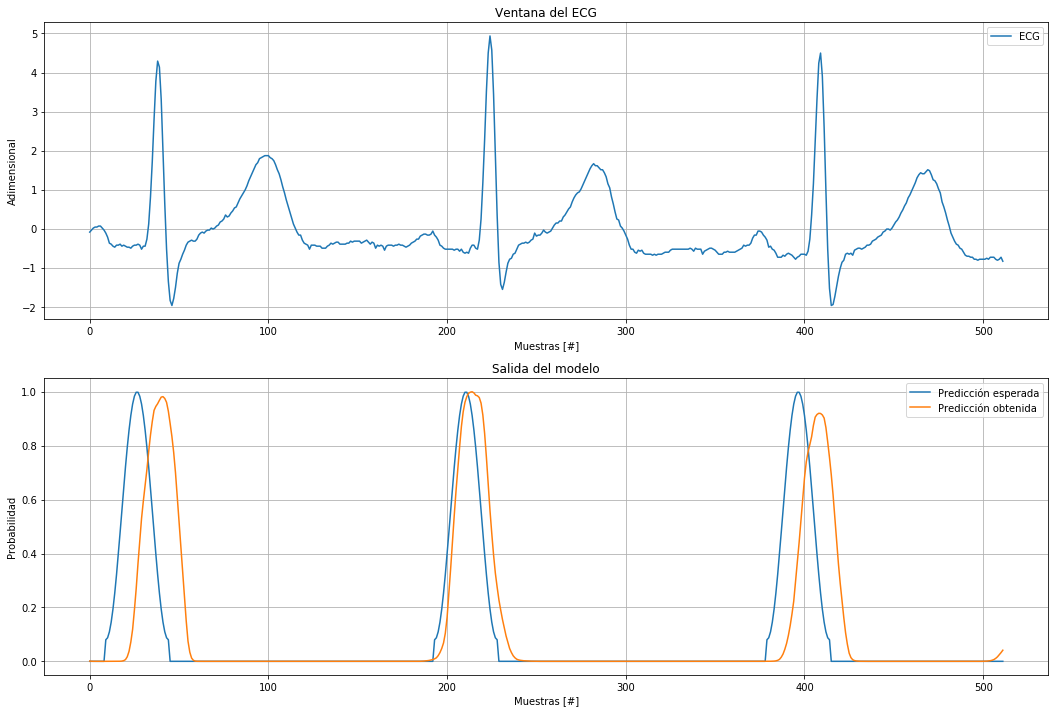

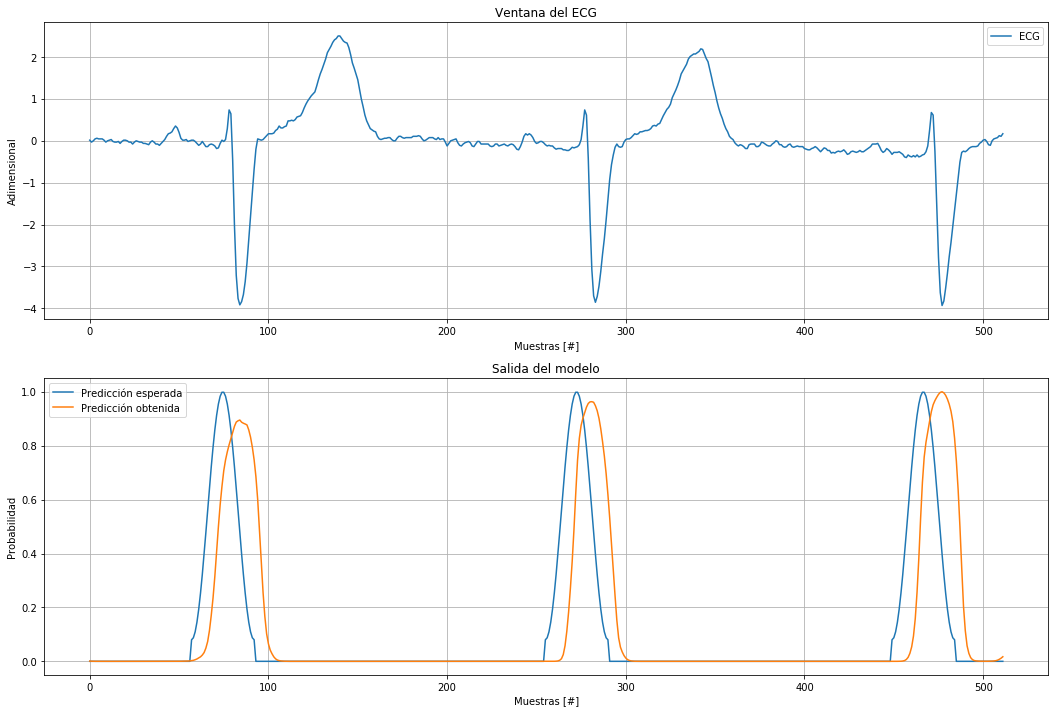

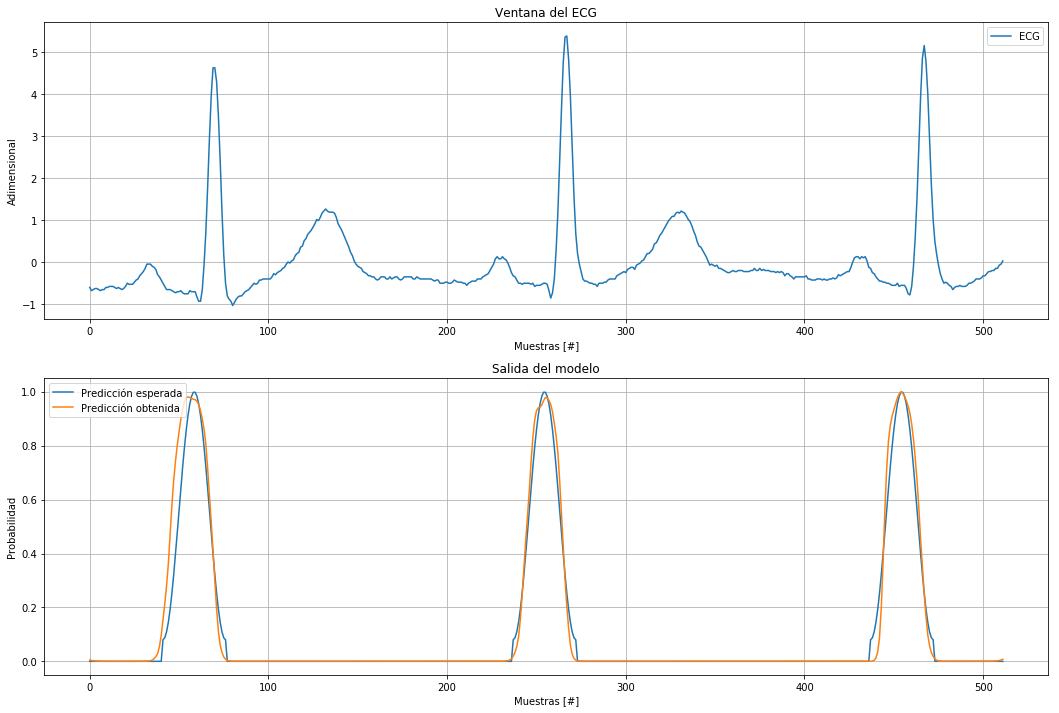

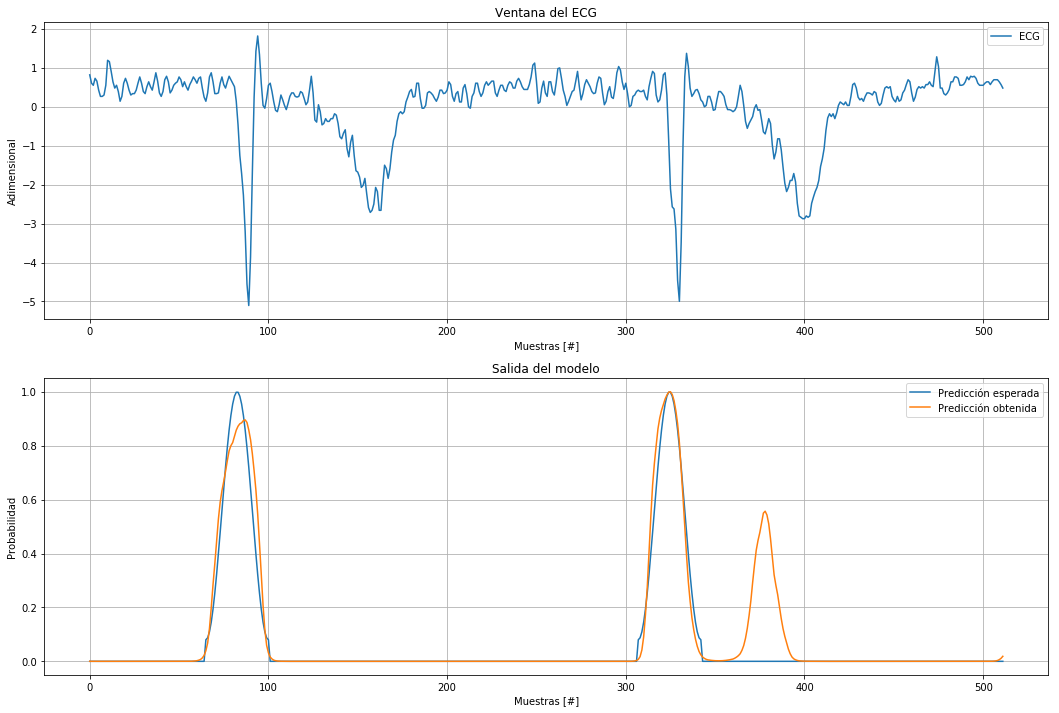

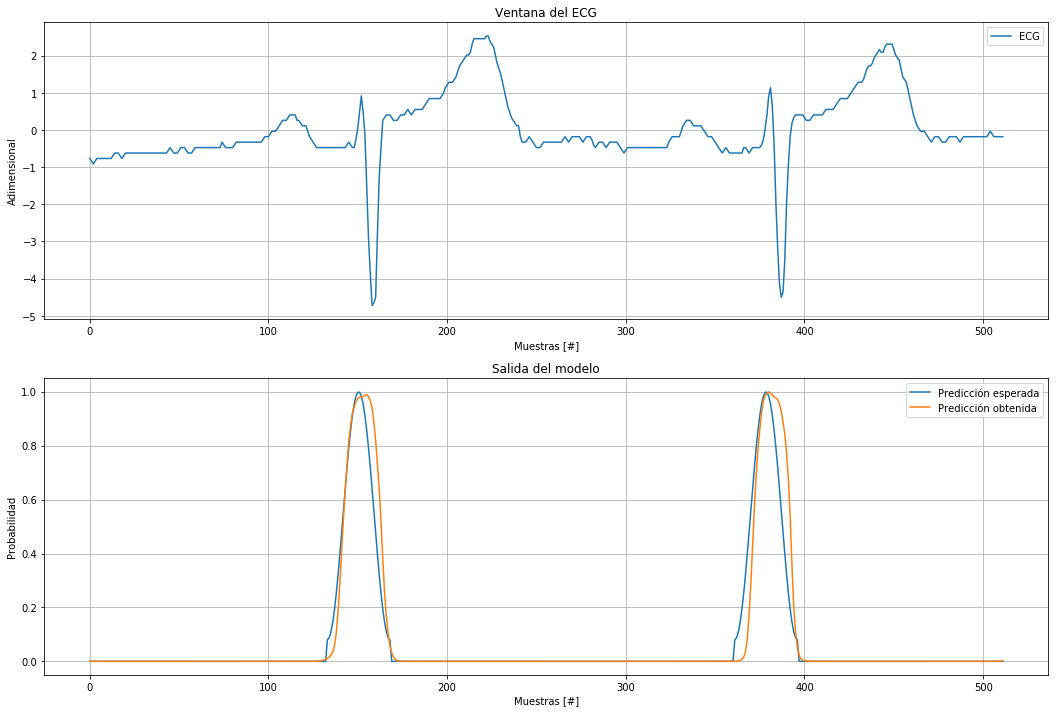

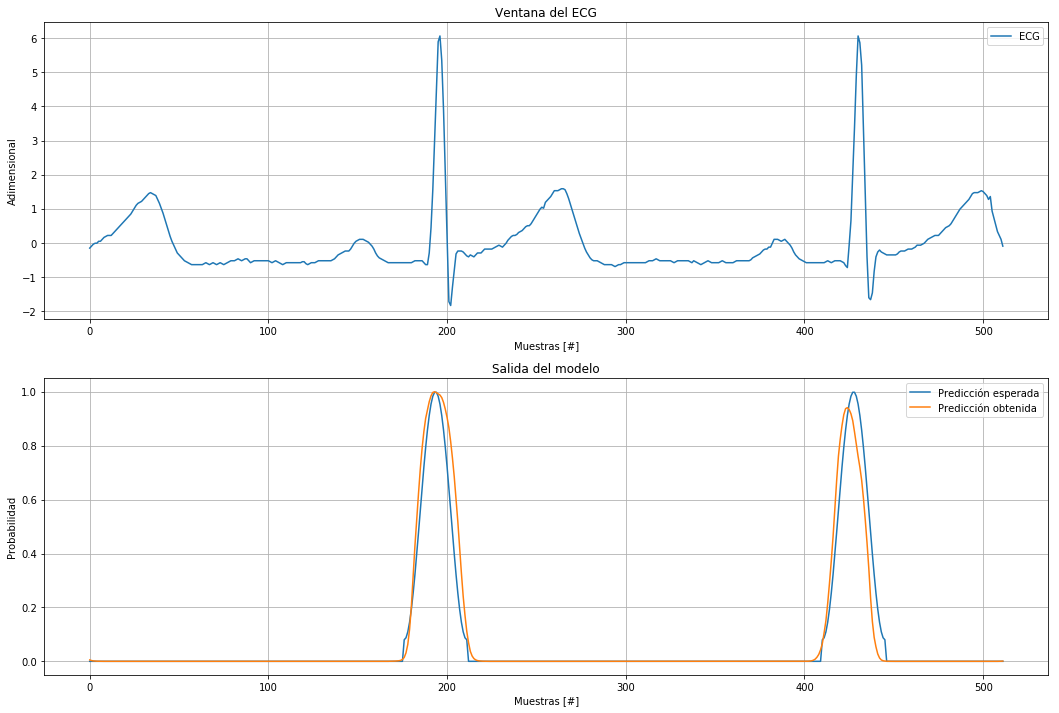

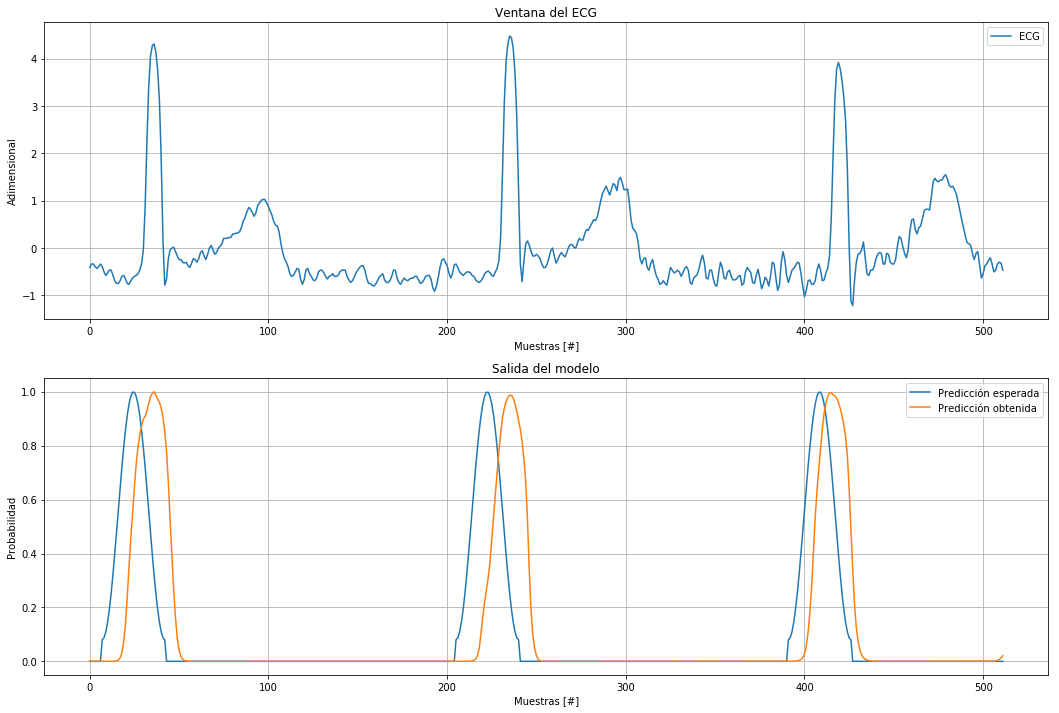

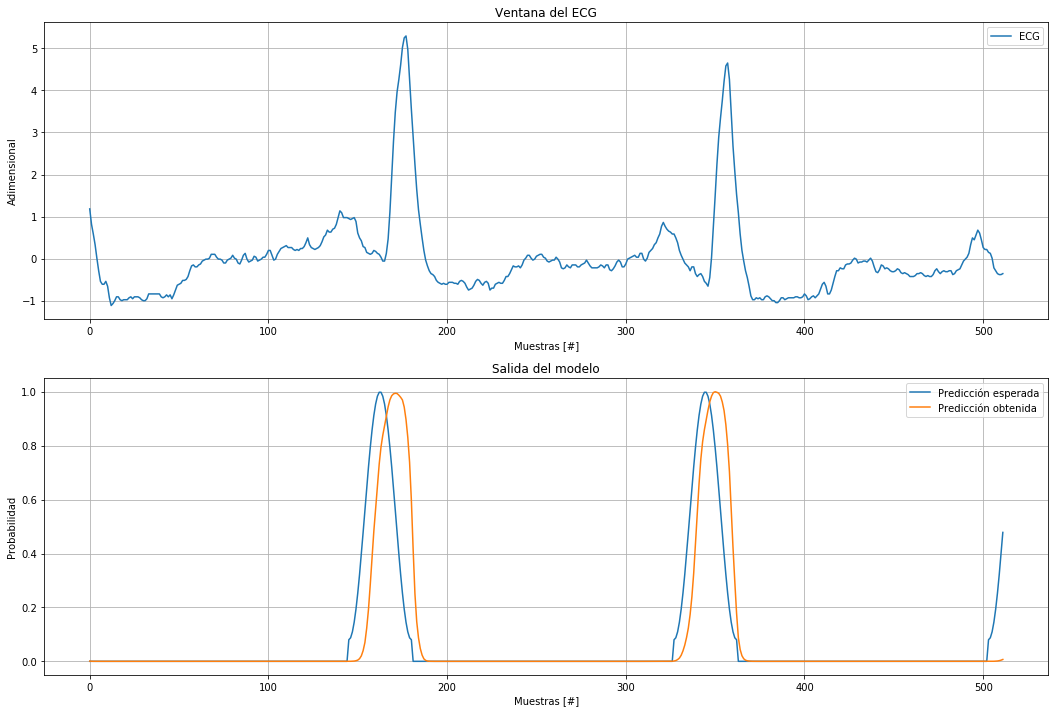

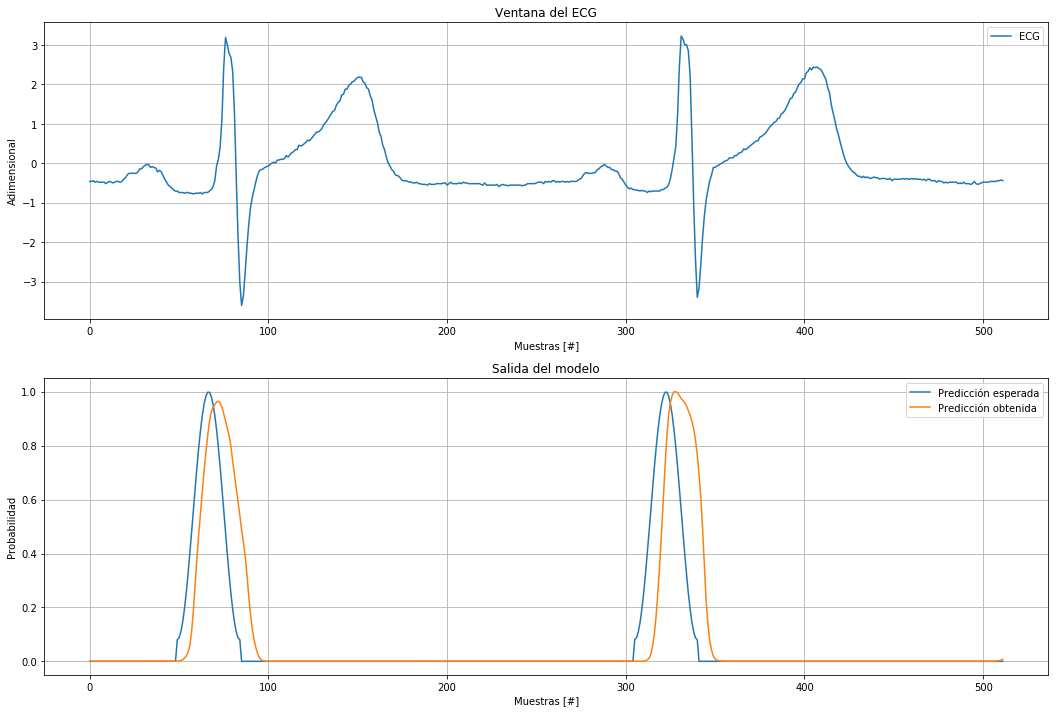

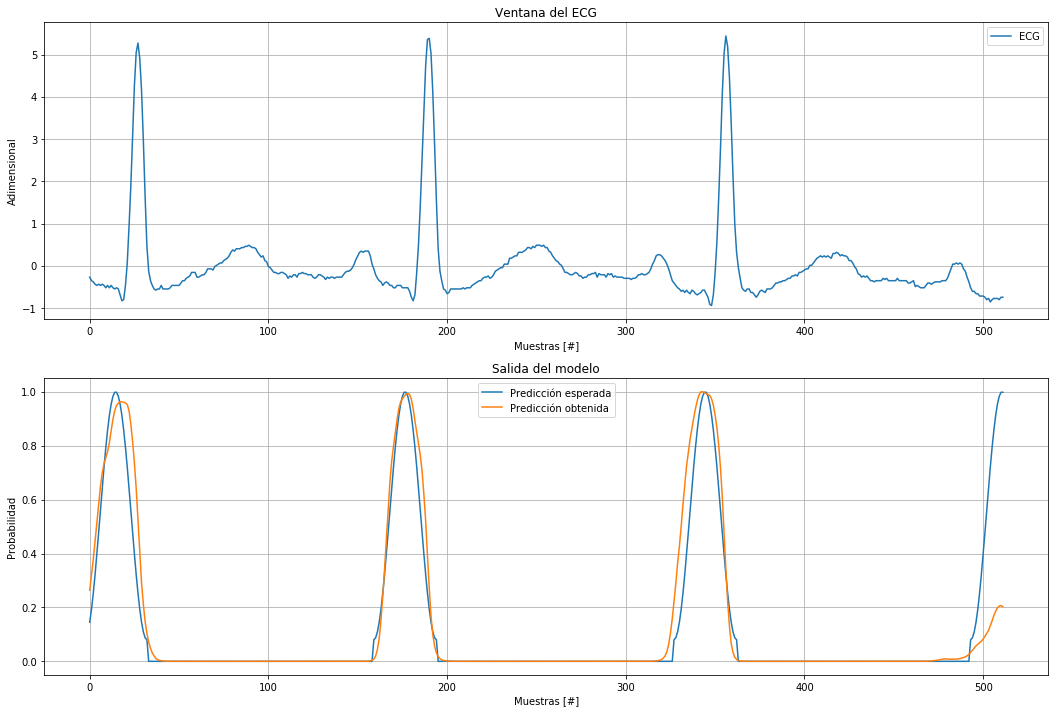

In [15]:
predictions = model.predict(test_input)

for i in examples:
    
    plt.figure(figsize=(18,12))
    plt.subplot(2,1,1)
    plt.plot(test_input[i], label = 'ECG')
    plt.title('Ventana del ECG')
    plt.xlabel('Muestras [#]')
    plt.ylabel('Adimensional')
    plt.grid()
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.plot(test_label[i], label = 'Predicción esperada')
    plt.plot(predictions[i] / (np.max(predictions[i]) + np.finfo(float).eps), label = 'Predicción obtenida')
    plt.title('Salida del modelo')
    plt.xlabel('Muestras [#]')
    plt.ylabel('Probabilidad')
    plt.grid()
    plt.legend()
    
np.save('data/pred_mod1', predictions)

Se calculan los parametros de performance...

In [16]:
verdadero_p = 0
falso_p = 0
falso_n = 0
total = 0

for sample_num in range(len(test_label)):

    picos_label, _ = signal.find_peaks(test_label[sample_num], height=0.5, distance = 70)
    total = total + len(picos_label)
    picos_pred, _ = signal.find_peaks(predictions[sample_num], height=0.5, distance = 70)

    hit = False

    for label in picos_label:
        for i in range(len(picos_pred)):
            if ((picos_pred[i] >= (label - 18)) and (picos_pred[i] <= (label + 18))):
                picos_pred = np.delete(picos_pred, i)
                verdadero_p = verdadero_p + 1
                hit = True
                break
        if hit == False:
            falso_n = falso_n + 1
        hit = False

    falso_p = falso_p + len(picos_pred)

acc_1 = 100*verdadero_p/total
tasa_error_1 = 100*(falso_n + falso_p)/total
sensibilidad_1 = 100*(verdadero_p)/(verdadero_p + falso_p)
f1_1 = 2*((verdadero_p/total)*(verdadero_p)/(verdadero_p + falso_p))/((verdadero_p/total)+(verdadero_p)/(verdadero_p + falso_p))

##### Análisis de entrenamiento

Se grafica la evolución del error cuadrático medio y error absoluto medio de validación y entrenamiento a lo largo de las épocas entrenadas.

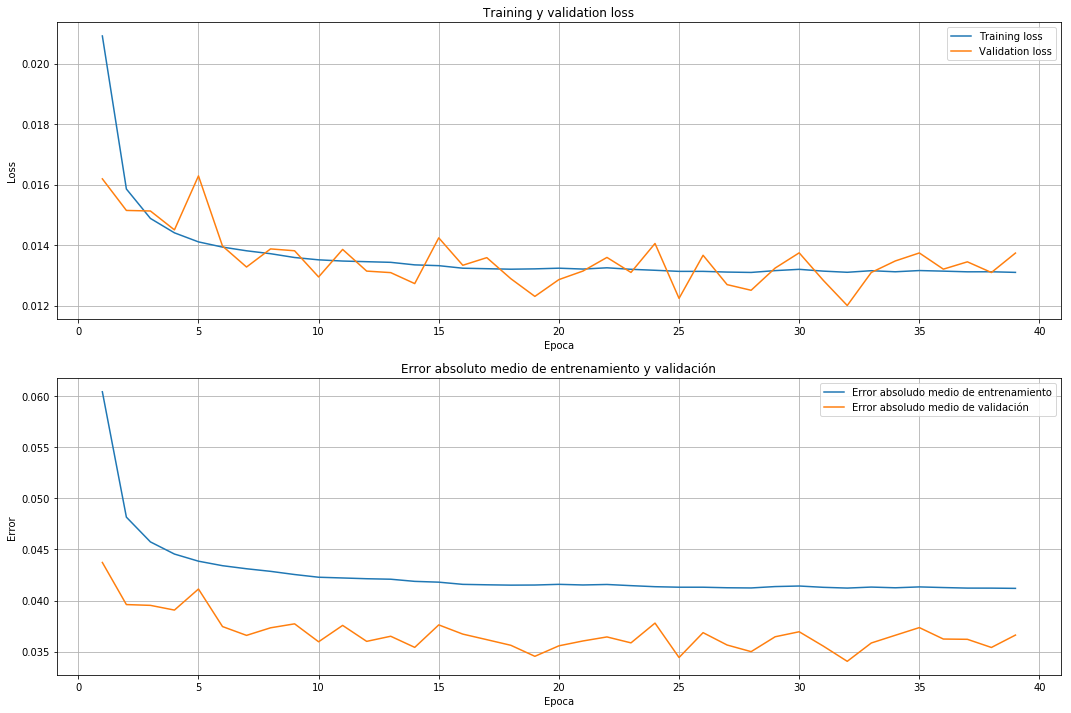

In [17]:
epochs = range(1, len(history.history['mean_absolute_error']) + 1)

plt.figure(figsize=(18,12))

plt.subplot(2,1,1)


plt.plot(epochs, history.history['loss'], label = 'Training loss')
plt.plot(epochs, history.history['val_loss'], label = 'Validation loss')
plt.title('Training y validation loss')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.subplot(2,1,2)

plt.plot(epochs, history.history['mean_absolute_error'], label = 'Error absoludo medio de entrenamiento')
plt.plot(epochs, history.history['val_mean_absolute_error'], label = 'Error absoludo medio de validación')
plt.title('Error absoluto medio de entrenamiento y validación')
plt.xlabel('Epoca')
plt.ylabel('Error')
plt.grid()
plt.legend()

### Comparación de desempeño

In [18]:
tus_resultados = [  
                   [acc_1, tasa_error_1, sensibilidad_1, f1_1],
                 ]

df = DataFrame(tus_resultados, columns=['Accuracy', 'Tasa de error', 'Sensibilidad', 'F1 Score'],
               index=["Modelo"])
HTML(df.to_html())

,Accuracy,Tasa de error,Sensibilidad,F1 Score
Modelo,97.070968,7.50245,95.500569,0.962794
